<a href="https://colab.research.google.com/github/myazann/Lung_Cancer/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' > /dev/null

!rm -rf sample_data
!rm sample.py
!rm README.md

!cp ./drive/MyDrive/bboxs.json .
!cp ./drive/MyDrive/lung_ct_train.zip .
!cp ./drive/MyDrive/lung_ct_val.zip .

!unzip lung_ct_train.zip > /dev/null
!rm lung_ct_train.zip
!unzip lung_ct_val.zip > /dev/null
!rm lung_ct_val.zip

In [2]:
import pandas as pd
import json
import os
import copy
import random
import numpy as np
import torchvision.transforms as transforms
import torch
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import itertools
import torchvision

from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader
import detectron2.data.transforms as T
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

## Create data according to Detectron dataset format


In [3]:
category_map = {
                "A": 0,
                "B": 1,
                "E": 2,
                "G": 3,
                0: "A",
                1: "B",
                2: "E",
                3: "G"
                  }

def get_ct_scans(mode):

  with open('bboxs.json') as json_file:
    bboxs = json.load(json_file)

  dataset_dicts = []
  path = "lung_ct_" + mode

  for ptnt in os.listdir(path):
    for i, img in enumerate(os.listdir(path + "/" + ptnt)):

      label = {}
      bboxes = bboxs[img.split(".j")[0]]

      label["file_name"] = path + "/" + ptnt + "/" + img
      label["image_id"] = i
      label["height"] = 512
      label["width"] = 512
      annot = []
      boxes = {
      "bbox": [int(bboxes["xmin"]), int(bboxes["ymin"]), int(bboxes["xmax"]), int(bboxes["ymax"])],
      "bbox_mode": BoxMode.XYXY_ABS,
      "category_id": category_map[bboxes["class"]],
      }
      annot.append(boxes)
      label["annotations"] = annot

      dataset_dicts.append(label)  

  return dataset_dicts

for d in ["train", "val"]:
  DatasetCatalog.register("ct_" + d, lambda d=d: get_ct_scans(d))
  MetadataCatalog.get("ct_" + d).set(thing_classes=["A", "B", "E", "G"], evaluator_type="coco")

ct_train = DatasetCatalog.get("ct_train")
ct_val = DatasetCatalog.get("ct_val")

ct_metadata = MetadataCatalog.get("ct_train")

## Class Distributions

In [4]:
pd.Series([category_map[k["annotations"][0]["category_id"]] for k in ct_train]).value_counts()

A    4133
G    1269
B     422
E      14
dtype: int64

In [5]:
pd.Series([category_map[k["annotations"][0]["category_id"]] for k in ct_val]).value_counts()

A    1195
B     314
G     273
dtype: int64

## Created a customer trainer to enable evaluation 

In [6]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")

        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type

        if evaluator_type in ["coco", "coco_panoptic_seg"]:
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))

        elif evaluator_type == "pascal_voc":
            return PascalVOCDetectionEvaluator(dataset_name)

        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)

## Training

In [16]:
cfg = get_cfg()

train_data_loader = build_detection_train_loader(
    DatasetCatalog.get("ct_train"), total_batch_size = 64,
    mapper=DatasetMapper(cfg, is_train=True, augmentations=[
    T.RandomContrast(0.5, 1.5),
    T.RandomFlip(0.75, horizontal=False, vertical=True),
    T.RandomLighting(0.5),
    T.RandomRotation(30),
    T.RandomSaturation(0.5, 1.5)

    ], image_format="BGR"))

test_data_loader = build_detection_test_loader(
    DatasetCatalog.get("ct_val"),
    mapper=DatasetMapper(cfg, is_train=False, augmentations=[], image_format="BGR"))


cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ct_train", )
cfg.DATASETS.TEST = ("ct_val", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 

cfg.SOLVER.BASE_LR = 0.0005  
cfg.SOLVER.MAX_ITER = 3000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   ##512 leads to overfitting, 128 underfits.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False) ## False if its the first time.
trainer.train()

[04/25 10:58:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomContrast(intensity_min=0.5, intensity_max=1.5), RandomFlip(prob=0.75, horizontal=False, vertical=True), RandomLighting(scale=0.5), RandomRotation(angle=(30, 30)), RandomSaturation(intensity_min=0.5, intensity_max=1.5)]
[04/25 10:58:21 d2.data.common]: Serializing 5838 elements to byte tensors and concatenating them all ...
[04/25 10:58:21 d2.data.common]: Serialized dataset takes 1.52 MiB
[04/25 10:58:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: []
[04/25 10:58:21 d2.data.common]: Serializing 1782 elements to byte tensors and concatenating them all ...
[04/25 10:58:22 d2.data.common]: Serialized dataset takes 0.46 MiB
[04/25 10:58:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fp

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[04/25 10:58:23 d2.engine.train_loop]: Starting training from iteration 0
[04/25 10:59:17 d2.utils.events]:  eta: 2:15:09  iter: 19  total_loss: 1.895  loss_cls: 1.725  loss_box_reg: 0.0491  loss_rpn_cls: 0.1188  loss_rpn_loc: 0.00963  time: 2.7285  data_time: 0.2084  lr: 9.9905e-06  max_mem: 11769M
[04/25 11:00:11 d2.utils.events]:  eta: 2:12:42  iter: 39  total_loss: 1.515  loss_cls: 1.319  loss_box_reg: 0.05087  loss_rpn_cls: 0.1223  loss_rpn_loc: 0.01062  time: 2.7083  data_time: 0.2025  lr: 1.998e-05  max_mem: 11770M
[04/25 11:01:05 d2.utils.events]:  eta: 2:11:45  iter: 59  total_loss: 0.8751  loss_cls: 0.6911  loss_box_reg: 0.06029  loss_rpn_cls: 0.1141  loss_rpn_loc: 0.0105  time: 2.7017  data_time: 0.1984  lr: 2.997e-05  max_mem: 11770M
[04/25 11:01:59 d2.utils.events]:  eta: 2:11:01  iter: 79  total_loss: 0.5134  loss_cls: 0.3005  loss_box_reg: 0.07304  loss_rpn_cls: 0.1171  loss_rpn_loc: 0.01005  time: 2.6977  data_time: 0.1998  lr: 3.9961e-05  max_mem: 11770M
[04/25 11:02:5

## Let's visualize some of the predictions

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25   
predictor = DefaultPredictor(cfg)

In [18]:
##Function to visualize an image with its corresponding label

def get_img_with_bbox(im, labels, outputs):

  d_im = copy.deepcopy(im.squeeze())
  gt_bbox = labels["bbox"]
  gt_class = category_map[labels["category_id"]]

  v = Visualizer(d_im[:, :, ::-1],
                metadata=ct_metadata, 
                scale=1,
                instance_mode = 1)

  if len(outputs.get_fields()["pred_boxes"]) != 0:

    out = outputs[0].get_fields()["pred_boxes"][0].tensor[0]
    label = category_map[outputs[0].get_fields()["pred_classes"][0].item()]
    score = "{:.0%}".format(outputs[0].get_fields()["scores"][0].item())
    text = "Pred:" + label + " " + score

    xmin = out[0]
    ymin = out[1]
    xmax = out[2]
    ymax = out[3]

    cv2.rectangle(d_im, (xmin, ymin), (xmax, ymax), (255, 255, 255), 2)
    cv2.putText(d_im, text, (xmin-50,ymin-10), cv2.FONT_HERSHEY_DUPLEX, fontScale=0.5, color=(255, 255, 255), thickness=1)

  ##out = v.draw_instance_predictions(outputs.to("cpu"))
  ##d_im = out.get_image()

  xmin = gt_bbox[0]
  ymin = gt_bbox[1]
  xmax = gt_bbox[2]
  ymax = gt_bbox[3]

  cv2.rectangle(d_im, (xmin, ymin), (xmax, ymax), (255, 200, 200), 2)
  cv2.putText(d_im, "Real:" + gt_class, (xmax,ymax+10), cv2.FONT_HERSHEY_DUPLEX, fontScale=0.5, color=(255, 200, 200), thickness=1)

  display(Image.fromarray(d_im))

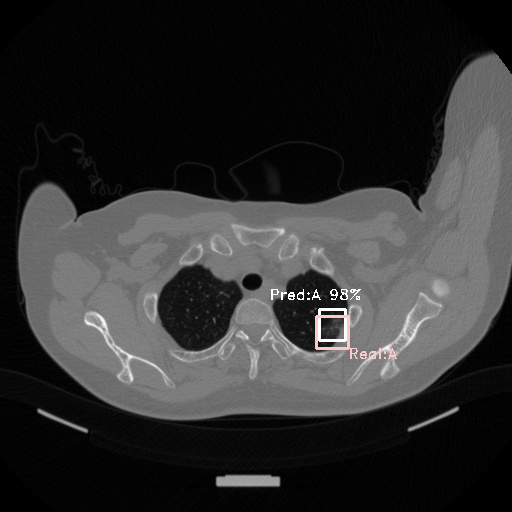

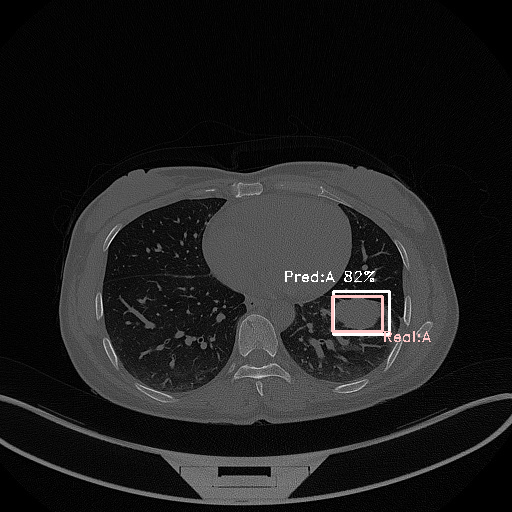

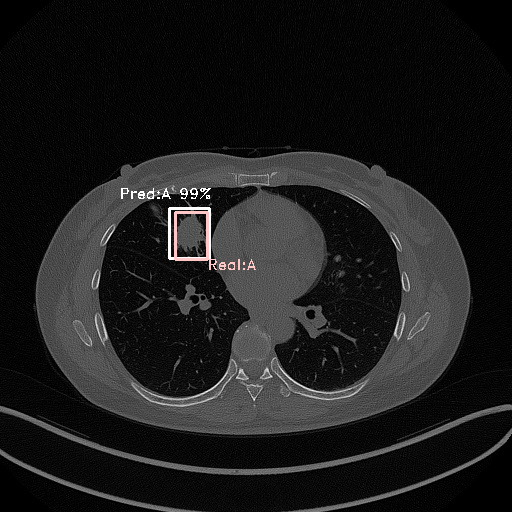

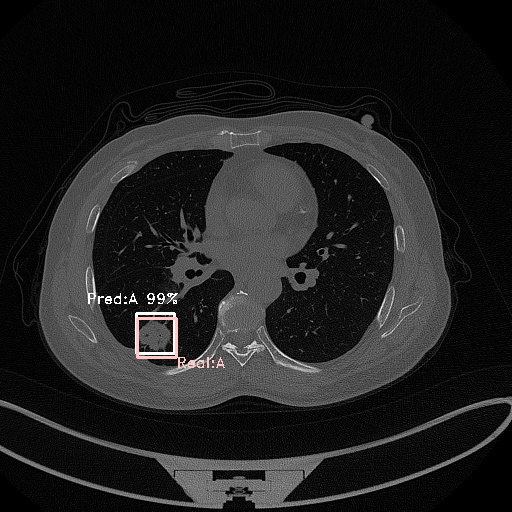

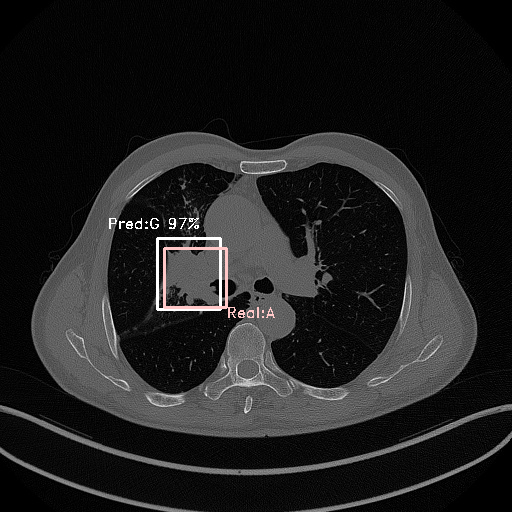

In [20]:
rs = random.sample(range(0, len(ct_val)), 5)

for elem in rs:
  img = cv2.imread(ct_val[elem]["file_name"])
  outputs = predictor(img)["instances"]
  
  get_img_with_bbox(img, ct_val[elem]["annotations"][0], outputs)
  print("\n")